Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [69]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
    Input,
)

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [53]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
if "bus.zip" in os.listdir():
    pass
else:
    gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
if "bus" in os.listdir():
    pass
else:
    !unzip -q "bus.zip" -d bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = 'bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Входящий', 'Выходящий']

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [5]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['06433.jpg', '01502.jpg', '00428.jpg', '03205.jpg', '00621.jpg', '00559.jpg', '04150.jpg', '04198.jpg', '02286.jpg', '01925.jpg', '05426.jpg', '00054.jpg', '01649.jpg', '04619.jpg', '03349.jpg', '03705.jpg', '06248.jpg', '02365.jpg', '03482.jpg', '05354.jpg', '04784.jpg', '00064.jpg', '05639.jpg', '00124.jpg', '03535.jpg', '05904.jpg', '02014.jpg', '00048.jpg', '01024.jpg', '01573.jpg', '01829.jpg', '02605.jpg', '06223.jpg', '02041.jpg', '01054.jpg', '01986.jpg', '00512.jpg', '00182.jpg', '00211.jpg', '01997.jpg', '03557.jpg', '00009.jpg', '04739.jpg', '03692.jpg', '05196.jpg', '01081.jpg', '06001.jpg', '04132.jpg', '06234.jpg', '01530.jpg', '03583.jpg', '05025.jpg', '02401.jpg', '03605.jpg', '04798.jpg', '00775.jpg', '04624.jpg', '04805.jpg', '05784.jpg', '00335.jpg', '04580.jpg', '04156.jpg', '01645.jpg', '02234.jpg', '02211.jpg', '01838.jpg', '02011.jpg', '04043.jpg', '00485.jpg', '02692.jpg', '00463.jpg', '05412.jpg', '06217.jpg', '04089.jpg', '05653.jpg', '04305.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

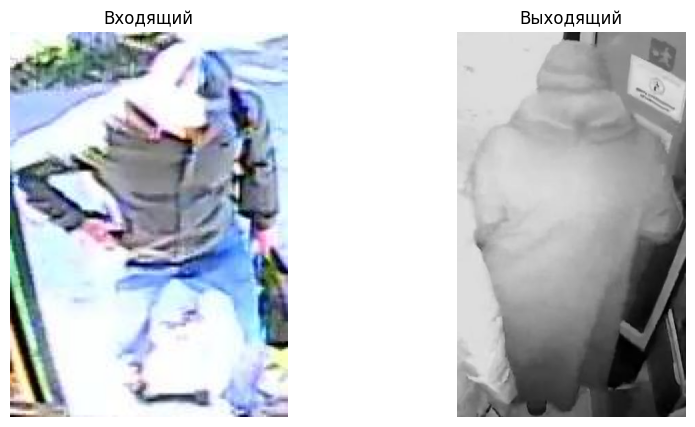

In [6]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [7]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 4687 фото
Размер класса Выходящий составляет 1876 фото

Общий размер базы для обучения: 6563


In [8]:
from pathlib import Path

In [54]:
TEST_SPLIT = VAL_SPLIT = 0.15
TRAIN_PATH = Path("bus")
VAL_PATH = Path("bus_val")
TEST_PATH = Path("bus_test")

if not (TEST_PATH.exists() and VAL_PATH.exists()):
    TEST_PATH.mkdir(exist_ok=True)
    VAL_PATH.mkdir(exist_ok=True)

    for classfolder in TRAIN_PATH.iterdir():
        classfolder_test = TEST_PATH / classfolder.name
        classfolder_val = VAL_PATH / classfolder.name

        classfolder_test.mkdir(exist_ok=True)
        classfolder_val.mkdir(exist_ok=True)

        files = list(classfolder.iterdir())
        len_class = len(files)
        test_len = int(len_class * TEST_SPLIT)
        val_len = int(len_class * VAL_SPLIT)
        
        for i, img in enumerate(files):
            if i < test_len:
                img.rename(classfolder_test / img.name)
            elif i < test_len + val_len:
                img.rename(classfolder_val / img.name)
            else:
                break


In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [56]:
# ваше решение
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

In [57]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32


In [59]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    seed=42,
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    seed=42,
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
    seed=42,
)


Found 6359 images belonging to 2 classes.
Found 1361 images belonging to 2 classes.
Found 1361 images belonging to 2 classes.


In [60]:
print("Train class distribution:", np.bincount(train_generator.classes))
print("Validation class distribution:", np.bincount(validation_generator.classes))
print("Test class distribution:", np.bincount(test_generator.classes))


Train class distribution: [4541 1818]
Validation class distribution: [972 389]
Test class distribution: [972 389]


In [80]:
model = Sequential(
    [
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Dropout(0.1),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Dropout(0.1),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.1),
        Dense(256, activation="relu"),
        Dropout(0.1),
        Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [81]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,505 (2.49 MB)

 Trainable params: 652,545 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [82]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=1,
)

Epoch 1/50


199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7715 - loss: 0.5134 - val_accuracy: 0.7472 - val_loss: 0.6075
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8963 - loss: 0.2526 - val_accuracy: 0.7171 - val_loss: 0.5248
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9319 - loss: 0.1661 - val_accuracy: 0.8920 - val_loss: 0.2251
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9471 - loss: 0.1223 - val_accuracy: 0.9346 - val_loss: 0.1469
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9651 - loss: 0.0896 - val_accuracy: 0.9390 - val_loss: 0.1415
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9782 - loss: 0.0594 - val_accuracy: 0.9434 - val_loss: 0.1416
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9815 - loss: 0.0481 - val_accuracy: 0.9324 - val_loss: 0.2034
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9819 - loss: 0.0474 - val_accuracy: 0.96

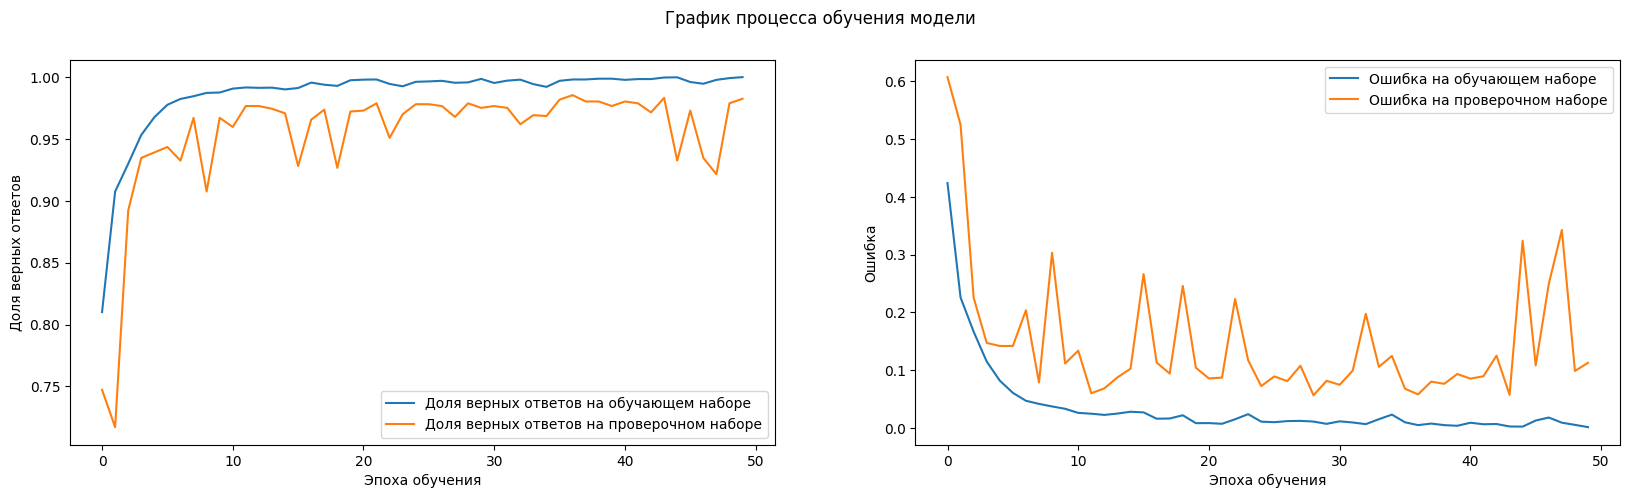

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'],
            label='Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'],
            label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()

In [84]:
model.save_weights("mid.weights.h5")

In [17]:
model.load_weights("mid.weights.h5")

/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [85]:
loss, acc = model.evaluate(test_generator)
print(f"Accuracy: {acc}, loss: {loss}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9900 - loss: 0.0571
Accuracy: 0.9860396981239319, loss: 0.08558925986289978
